In [9]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import gridspec
import copy

from EightBitTransit.cTransitingImage import TransitingImage
from EightBitTransit.inversion import *
from EightBitTransit.misc import *
from scipy.optimize import lsq_linear

%matplotlib inline

# Hello! Welcome to EightBitTransit.

## First: how can we calculate the transit light curve of an arbitrary pixelated image?

### Option 1: Read in an image file.
### Option 2: Specify an opacity matrix.

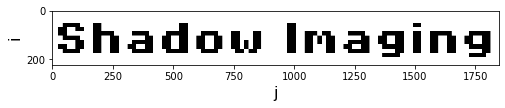

(223, 1847)


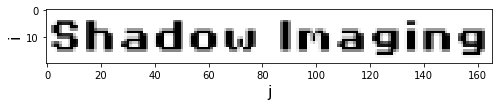

(20, 166)


In [2]:
# Option 1: Read in an image file.

# an array of times, in days, over which to calculate the light curve 
times = np.linspace(-35.,35.,500)

# create a TransitingImage object, which reads in an image file and converts it into a matrix of pixels
# transiting the star at velocity v [days**-1], with reference time t_ref [days]
SItitle = TransitingImage(imfile="./ShadowImagingTitle.png",
                          v=0.4,
                          t_ref=0.,
                          t_arr=times)
SItitle.plot_grid()
print(np.shape(SItitle.opacitymat)) # the pixelated image grid. Notice that this is very high-resolution, so the 
                                   # light curve calculation in the next cell would be slow.

# We can speed up the light curve calculation by specifying a lower image resolution, e.g. 20 pixels in height.
# The image aspect ratio will not change.
lowres_SItitle = TransitingImage(imfile="./ShadowImagingTitle.png",
                                 lowres=20,
                                 lowrestype="mean", # Calculate the lower-resolution version of the image by averaging "neighborhoods" of pixels in the high-res image.
                                 lowresround=False, # Let the resulting low-res pixel values take on intermediate values between 0 and 1, i.e. don't round them to 0 or 1.
                                 v=0.4,
                                 t_ref=0.,
                                 t_arr=times)
lowres_SItitle.plot_grid()
print(np.shape(lowres_SItitle.opacitymat))

In [3]:
# Calculate the light curve for this object. This function returns two arrays:
#    overlapTimes = the time steps at which the image grid has nonzero overlap with the star, given your choice of times and v;
#    SItitle_LC = array of relative fluxes at those time steps
lowres_SItitle_LC, overlapTimes = lowres_SItitle.gen_LC(t_arr=times) 

/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


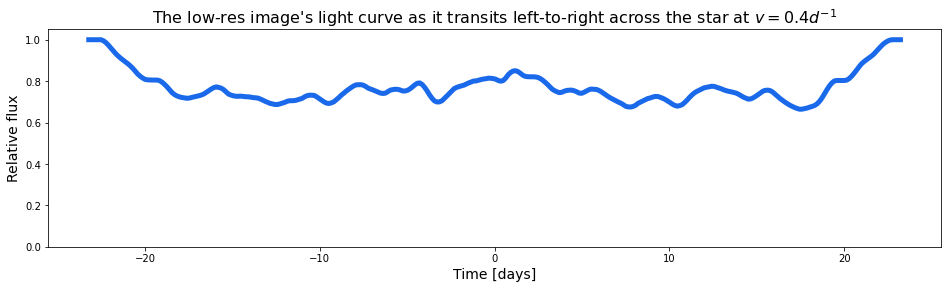

In [4]:
fig, ax = plt.subplots(1,1,figsize=(16,4))
ax.plot(overlapTimes,lowres_SItitle_LC,color="#1969ea",ls="-",lw=5)
ax.set_ylim(0.0,1.05)
plt.xlabel("Time [days]",fontsize=14)
plt.ylabel("Relative flux",fontsize=14)
plt.title(r"The low-res image's light curve as it transits left-to-right across the star at $v = 0.4 d^{-1}$",fontsize=16)
plt.show()

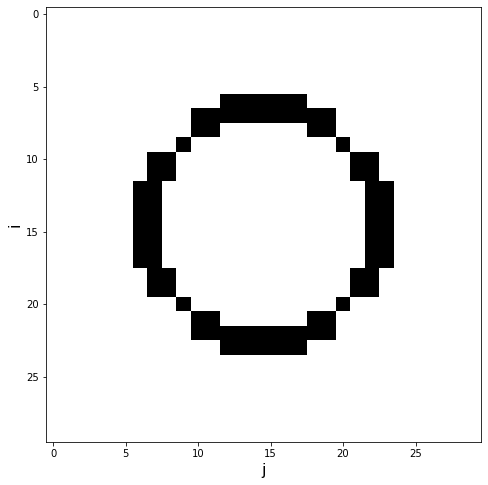

/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:43: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


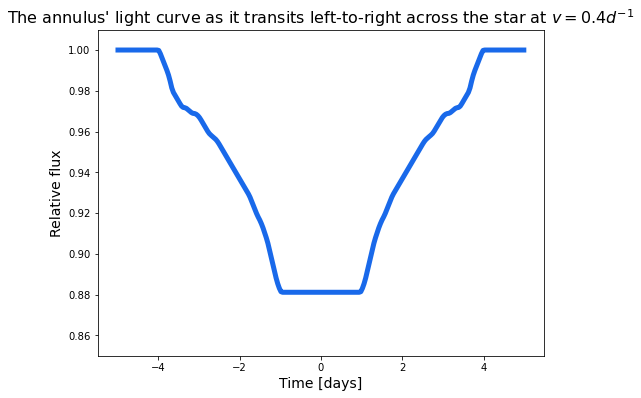

In [5]:
# Option 2: Specify an opacity matrix.
times = np.linspace(-10.,10.,500)

# set up the grid
an_grid = np.zeros((30,30))
an_grid[6:9,12:18] = 1
an_grid[7:9,10:20] = 1
an_grid[8:9,12:18] = 0
an_grid[9:10,9:21] = 1
an_grid[9:10,10:20] = 0
an_grid[10:11,7:23] = 1
an_grid[10:11,9:21] = 0
an_grid[11:12,7:23] = 1
an_grid[11:12,9:21] = 0
an_grid[12:15,6:24] = 1
an_grid[12:15,8:22] = 0

an_grid[15:18,6:24] = 1
an_grid[15:18,8:22] = 0

an_grid[18:19,7:23] = 1
an_grid[18:19,9:21] = 0

an_grid[19:20,7:23] = 1
an_grid[19:20,9:21] = 0

an_grid[20:21,9:21] = 1
an_grid[20:21,10:20] = 0

an_grid[21:23,10:20] = 1
an_grid[21:24,12:18] = 1
an_grid[21:22,12:18] = 0


# create a TransitingImage object, which reads in an image file and converts it into a matrix of pixels
# transiting the star at velocity v [days**-1], with reference time t_ref [days]
annulus = TransitingImage(opacitymat=an_grid,
                          v=0.4,
                          t_ref=0.,
                          t_arr=times)
annulus.plot_grid()

annulus_LC, overlapTimes = annulus.gen_LC(t_arr=times) 

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(overlapTimes,annulus_LC,color="#1969ea",ls="-",lw=5)
ax.set_ylim(0.85,1.01)
plt.xlabel("Time [days]",fontsize=14)
plt.ylabel("Relative flux",fontsize=14)
plt.title(r"The annulus' light curve as it transits left-to-right across the star at $v = 0.4 d^{-1}$",fontsize=16)
plt.show()

## Second: how do we recover a shadow image from an observed light curve?


In [6]:
# Here, we present an inversion of Dip 5 of Boyajian's Star, by all four of the available inversion algorithm.
# This code reproduces figure 12 of Sandford et al. 2018.

# Limb-darkening coefficients interpolated from Sing (2010):
LDlaw="quadratic"
LDCs = [0.2644, 0.3303]

data = np.genfromtxt("./boyajian_dip5_data.csv",delimiter=",")

times = data[:,0]
truth_LC = data[:,1]
truth_LC_err = data[:,2]

v = 0.4


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:190: UserWarning: Small-planet approximation for LD calculation is inappropriate. Choose higher N if possible.
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:193: UserWarning: Small-planet approximation for LD calculation is inappropriate. Choose higher N if possible.


lowest-RMS method is: constrained least squares
v = 0.8


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:190: UserWarning: Small-planet approximation for LD calculation is inappropriate. Choose higher N if possible.
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:193: UserWarning: Small-planet approximation for LD calculation is inappropriate. Choose higher N if possible.


lowest-RMS method is: constrained least squares
v = 1.6


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:28: UserWarning: Small-planet approximation for LD calculation is inappropriate. Choose higher N if possible.
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:64: UserWarning: Small-planet approximation for LD calculation is inappropriate. Choose higher N if possible.
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:68: UserWarning: Small-planet approximation for LD calculation is inappropriate. Choose higher N if possible.
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:100: UserWarning: Small-planet approximation for LD calculation is inappropriate. Choose higher N if possible.
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:101: UserWarning: Small-planet approximation for LD calculation is inappropriate. Choose higher N if possible.
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:104: UserW

lowest-RMS method is: constrained least squares
v = 3.2


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:28: UserWarning: Small-planet approximation for LD calculation is inappropriate. Choose higher N if possible.
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:64: UserWarning: Small-planet approximation for LD calculation is inappropriate. Choose higher N if possible.
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:68: UserWarning: Small-planet approximation for LD calculation is inappropriate. Choose higher N if possible.
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:100: UserWarning: Small-planet approximation for LD calculation is inappropriate. Choose higher N if possible.
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:101: UserWarning: Small-planet approximation for LD calculation is inappropriate. Choose higher N if possible.
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:104: UserW

lowest-RMS method is: constrained least squares


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:251: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error two minor releases later


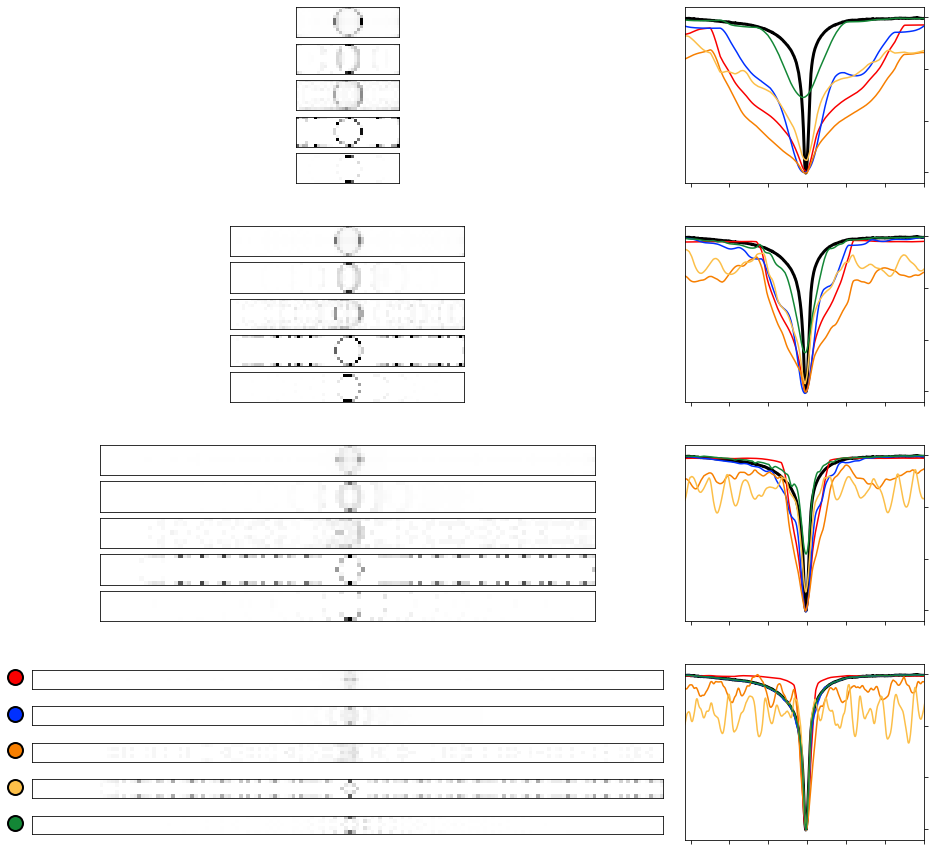

In [17]:
test_vs = np.array((0.4,0.8,1.6,3.2))

t_ref=1.4405785

fig = plt.figure(figsize=(16,4*len(test_vs)))
gs = gridspec.GridSpec(len(test_vs)*6, 7)

maxmax=0.

for i in range(0, len(test_vs)):
    v = test_vs[i]
    print("v = {0}".format(v))
    
    # N chosen to be the highest possible integer value at each v, given that M is calculated from v (see below)
    # and that N * M cannot exceed the number of observed data points.
    if v < 1.0:
        N = 10
    elif v < 2.0:
        N = 7
    else:
        N = 5
    
    w = 2./N
    M = int(np.ceil((2.*(t_ref - np.min(times))*v - 2.)/w))
    
    
    ti = TransitingImage(opacitymat=np.zeros((N,M)), LDlaw=LDlaw, LDCs=LDCs, v=v, t_ref=t_ref, t_arr=times)
    trial_LC, overlapTimes = ti.gen_LC(times)
    
    tMin = t_ref - (2. + ti.w*M)/(2.*v)
    tMax = t_ref + (2. + ti.w*M)/(2.*v)
    overlappingTimesMask = (times > tMin) & (times < tMax)
        
    overlappingObsLC = truth_LC[overlappingTimesMask]
    overlappingObsLCerr = truth_LC_err[overlappingTimesMask]
    
    # Since the light blocked by each pixel at each time step does not depend on the pixel's opacity, we can calculate it in advance to save time.
    try:
        LCdecs = np.load("./boyajianResults/boyajiansStar_dip5_LCdecs_v{0}_N{1}_M{2}.npy".format(v, N, M))
    except IOError:
        LCdecs = calculateLCdecrements(N=N,M=M,LDlaw=LDlaw, LDCs=LDCs, v=v, t_ref=t_ref, times=overlapTimes)
        np.save("./boyajianResults/boyajiansStar_dip5_LCdecs_v{0}_N{1}_M{2}.npy".format(v, N, M), LCdecs)
    
    arcAvg_ax = plt.subplot(gs[6*i, 0:5])
    SART_ax = plt.subplot(gs[6*i+1, 0:5])
    pars_ax = plt.subplot(gs[6*i+2, 0:5])
    comb_ax = plt.subplot(gs[6*i+3, 0:5])
    clsq_ax = plt.subplot(gs[6*i+4, 0:5])
    
    LC_ax = plt.subplot(gs[6*i:6*i+5, 5:])
    
    #Arc-averaging
    try: 
        arcAvg = np.load("./boyajianResults/boyajiansStar_dip5_arcAvg_v{0}_N{1}_M{2}.npy".format(v, N, M))
    except IOError:
        avgBasis = makeArcBasisAverage(N=N, M=M, t_ref=t_ref, v=v, LDlaw=LDlaw, LDCs=LDCs, times=overlapTimes, LCdecrements=LCdecs, obsLC=overlappingObsLC, obsLCerr=overlappingObsLCerr)
        arcAvg = np.mean(avgBasis,axis=0)
        np.save("./boyajianResults/boyajiansStar_dip5_arcAvg_v{0}_N{1}_M{2}.npy".format(v, N, M), arcAvg)

    arcAvg = arcAvg.reshape(N,M)
    arcAvg = ((arcAvg + arcAvg[::-1,:])/2.)
    
    arcAvg_ti = TransitingImage(opacitymat=arcAvg, LDlaw=LDlaw, LDCs=LDCs, v=v, t_ref=t_ref, t_arr=overlapTimes)
    arcAvg_LC, overlapTimes = arcAvg_ti.gen_LC(overlapTimes)
    
    arcAvg = renormBasis(arcAvg,arcAvg_LC,truth_LC)
    arcAvg_ti = TransitingImage(opacitymat=arcAvg, LDlaw=LDlaw, LDCs=LDCs, v=v, t_ref=t_ref, t_arr=overlapTimes)
    arcAvg_LC, overlapTimes = arcAvg_ti.gen_LC(overlapTimes)
    
    if np.max(arcAvg) > maxmax:
        maxmax = np.max(arcAvg)

    #SART
    try:
        raveledtau = np.genfromtxt("./boyajianResults/boyajiansStar_dip5_v{0}_quadraticLD_10000_N{1}_M{2}_taus_short.txt".format(v, N, M))
    except IOError:
        SARTgrid = invertLC(N=N,M=M, v=v, t_ref=t_ref, t_arr=overlapTimes, method="SART",
                            obsLC=overlappingObsLC, obsLCerr=overlappingObsLCerr,
                            LDlaw=LDlaw,LDCs=LDCs,
                            **{"n_iter":10000,"filename":"{0}{1}_quadraticLD_{2}_N{3}_M{4}".format("./boyajiansStar_dip5_v", v, 10000, N, M),"initstate":"uniform"})
        raveledtau = np.genfromtxt("./boyajianResults/boyajiansStar_dip5_v{0}_quadraticLD_10000_N{1}_M{2}_taus.txt".format(v, N, M))[-1]
    
    if (N>1) & (N%2 == 0): #N even
        #raveledtau = top pixels only 
        raveledtauHalf = np.reshape(copy.deepcopy(raveledtau), (int(N/2), M))
        raveledtau = np.zeros((N, M))
        raveledtau[0:int(N/2)] = raveledtauHalf
        for rowIdx in np.arange(N-1, int(N/2) - 1, -1):
            raveledtau[rowIdx] = raveledtauHalf[N - rowIdx - 1]
            
    elif (N>1) & (N%2 != 0):
        #raveledtau = top pixels + 1 row only 
        raveledtauHalf = np.reshape(copy.deepcopy(raveledtau), (int((N-1)/2 + 1), M))
        raveledtau = np.zeros((N, M))
        raveledtau[0:int((N-1)/2 + 1)] = raveledtauHalf
        for rowIdx in np.arange(N-1, int((N-1)/2), -1):
            raveledtau[rowIdx] = raveledtauHalf[N - rowIdx - 1]
    
    SART = raveledtau/2.
    SART = arcRearrange(grid=SART, v=v, t_ref=t_ref, times=overlapTimes, LDlaw=LDlaw, LDCs=LDCs)
    SART = arcRearrange(grid=SART, v=v, t_ref=t_ref, times=overlapTimes, LDlaw=LDlaw, LDCs=LDCs)
    
    SART_ti = TransitingImage(opacitymat=SART, LDlaw=LDlaw, LDCs=LDCs, v=v, t_ref=t_ref, t_arr=overlapTimes)
    SART_LC, overlapTimes = SART_ti.gen_LC(overlapTimes)
    
    #deal with edge effects: edge pixels can sometimes artificially blow up to large opaicty values because their overlap areas are very small.
    if (v == 0.8):
        SART[:,0:6] = 0.
        
    if (v == 1.6):
        SART[:,0:12] = 0.
    
    if (v == 3.2):
        SART[:,0:20] = 0.
    
    SART = renormBasis(SART, SART_LC, truth_LC)
    SART_ti = TransitingImage(opacitymat=SART, LDlaw=LDlaw, LDCs=LDCs, v=v, t_ref=t_ref, t_arr=overlapTimes)
    SART_LC, overlapTimes = SART_ti.gen_LC(overlapTimes)
    
    if np.max(SART) > maxmax:
        maxmax = np.max(SART)
    
    #dF/dt parsimony
    try: 
        pars = np.load("./boyajianResults/boyajiansStar_dip5_arcParsimony_v{0}_N{1}_M{2}.npy".format(v, N, M))
    except IOError:
        parsBasis = makeArcBasisParsimony(N=N, M=M, t_ref=t_ref, v=v, LDlaw=LDlaw, LDCs=LDCs, times=overlapTimes, LCdecrements=LCdecs, obsLC=overlappingObsLC, obsLCerr=overlappingObsLCerr)
        pars = np.mean(parsBasis,axis=0)
        np.save("./boyajianResults/boyajiansStar_dip5_arcParsimony_v{0}_N{1}_M{2}.npy".format(v, N, M), pars)
    
    pars = pars.reshape(N,M)
    pars = ((pars + pars[::-1,:])/2.)
    
    pars_ti = TransitingImage(opacitymat=pars, LDlaw=LDlaw, LDCs=LDCs, v=v, t_ref=t_ref, t_arr=overlapTimes)
    pars_LC, overlapTimes = pars_ti.gen_LC(overlapTimes)
    
    pars = renormBasis(pars,pars_LC,truth_LC)
    pars_ti = TransitingImage(opacitymat=pars, LDlaw=LDlaw, LDCs=LDCs, v=v, t_ref=t_ref, t_arr=overlapTimes)
    pars_LC, overlapTimes = pars_ti.gen_LC(overlapTimes)
    
    if np.max(pars) > maxmax:
        maxmax = np.max(pars)
    
    #arc combinatorics
    try:
        comb = np.load("./boyajianResults/boyajiansStar_dip5_arcCombinatorics_v{0}_N{1}_M{2}.npy".format(v, N, M))
    except IOError:
        combBasis = makeArcBasisCombinatoric(N=N, M=M, t_ref=t_ref, v=v, LDlaw=LDlaw, LDCs=LDCs, times=overlapTimes, LCdecrements=LCdecs, obsLC=overlappingObsLC, obsLCerr=overlappingObsLCerr)
        comb = np.mean(combBasis,axis=0)
        np.save("./boyajianResults/boyajiansStar_dip5_arcCombinatorics_v{0}_N{1}_M{2}.npy".format(v, N, M), comb)
    
    comb = comb.reshape(N,M)
    comb = ((comb + comb[::-1,:])/2.)
    
    comb_ti = TransitingImage(opacitymat=comb, LDlaw=LDlaw, LDCs=LDCs, v=v, t_ref=t_ref, t_arr=overlapTimes)
    comb_LC, overlapTimes = comb_ti.gen_LC(overlapTimes)
    
    comb = renormBasis(comb,comb_LC,truth_LC)
    comb_ti = TransitingImage(opacitymat=comb, LDlaw=LDlaw, LDCs=LDCs, v=v, t_ref=t_ref, t_arr=overlapTimes)
    comb_LC, overlapTimes = comb_ti.gen_LC(overlapTimes)
    
    if np.max(comb) > maxmax:
        maxmax = np.max(comb)
        
    
    #constrained least squares, based on code written by Kirill Tchernyshyov
    try:
        clsq = np.load("./boyajianResults/boyajiansStar_dip5_constrainedleastsquares_v{0}_N{1}_M{2}.npy".format(v, N, M))
    except IOError:
        sym_N = np.ceil(N / 2).astype(np.int)
        sym_design_matrix = symmetrize_design_matrix(LCdecs).reshape([sym_N * M, len(overlapTimes)]).T

        out_bounded = lsq_linear(sym_design_matrix, 1.-overlappingObsLC, bounds=[0., 1.])
        clsq = unfold_opacity_map(out_bounded['x'].reshape([sym_N, M]))
        clsq_LC = 1. - np.dot(sym_design_matrix, out_bounded['x'])

        np.save("./boyajianResults/boyajiansStar_dip5_constrainedleastsquares_v{0}_N{1}_M{2}.npy".format(v, N, M), clsq)
    
    #deal with edge effects: edge pixels can sometimes artificially blow up to large opaicty values because their overlap areas are very small.
    if (v == 0.8):
        clsq[:,0:6] = 0.
        
    if (v == 1.6):
        clsq[:,0:12] = 0.
    
    if (v == 3.2):
        clsq[:,0:20] = 0.
        
    clsq_ti = TransitingImage(opacitymat=clsq, LDlaw=LDlaw, LDCs=LDCs, v=v, t_ref=t_ref, t_arr=overlapTimes)
    clsq_LC, clsq_overlapTimes = clsq_ti.gen_LC(overlapTimes)
    
    clsq_ti = TransitingImage(opacitymat=clsq, LDlaw=LDlaw, LDCs=LDCs, v=v, t_ref=t_ref, t_arr=overlapTimes)
    clsq_LC, clsq_overlapTimes = clsq_ti.gen_LC(clsq_overlapTimes)
    
    clsq_overlappingTimesMask = (times >= np.min(clsq_overlapTimes)) & (times <= np.max(clsq_overlapTimes))
        
    clsq_overlappingObsLC = truth_LC[clsq_overlappingTimesMask]
    clsq_overlappingObsLCerr = truth_LC_err[clsq_overlappingTimesMask]
    
    if np.max(clsq) > maxmax:
        maxmax = np.max(clsq)
     
        
    methodList=["Arc-averaging","SART","dF/dt parsimony","Arc combinatorics","constrained least squares"]
    RMSarr = np.array((RMS(overlappingObsLC,overlappingObsLCerr,arcAvg_LC),RMS(overlappingObsLC,overlappingObsLCerr,SART_LC),RMS(overlappingObsLC,overlappingObsLCerr,pars_LC),RMS(overlappingObsLC,overlappingObsLCerr,comb_LC),RMS(clsq_overlappingObsLC,clsq_overlappingObsLCerr,clsq_LC)))
    
    bestMethod = methodList[np.argmin(RMSarr)]
    
    print("lowest-RMS method is: {0}".format(bestMethod))
    
    
    #plot images
    arcAvgImg = arcAvg_ax.imshow(arcAvg, cmap='Greys', interpolation='nearest',vmin=0.,vmax=maxmax)
    SARTImg = SART_ax.imshow(SART, cmap='Greys', interpolation='nearest',vmin=0.,vmax=maxmax)
    parsImg = pars_ax.imshow(pars, cmap='Greys', interpolation='nearest',vmin=0.,vmax=maxmax)
    combImg = comb_ax.imshow(comb, cmap='Greys', interpolation='nearest',vmin=0.,vmax=maxmax)
    clsqImg = clsq_ax.imshow(clsq, cmap='Greys', interpolation='nearest',vmin=0.,vmax=maxmax)
    
    #plot light curves
    LC_ax.plot(overlapTimes-t_ref, overlappingObsLC,'k-',lw=3,label='Truth')
    LC_ax.plot(overlapTimes-t_ref, arcAvg_LC,ls='-',lw=1.5,color='#F90000',label='Arc-averaging')
    LC_ax.plot(overlapTimes-t_ref, SART_LC,ls='-',lw=1.5,color='#0030FF',label='SART')
    LC_ax.plot(overlapTimes-t_ref, pars_LC,ls='-',lw=1.5,color='#F77F00',label='dF/dt parsimony')
    LC_ax.plot(overlapTimes-t_ref, comb_LC,ls='-',lw=1.5,color='#FCBF49',label='Arc combinatorics')
    LC_ax.plot(clsq_overlapTimes-t_ref, clsq_LC,ls='-',lw=1.5,color='#138736',label='Constrained least squares')
    
    LC_ax.set_ylim(np.min(truth_LC)-0.01,1.01)
    LC_ax.set_xlim(-4.85-t_ref, 6.01)
    
    #plot formatting
    if i==3:
        arcAvg_ax.plot(np.array((-5)), np.array((N/2.)), marker='o',mec='k',mew=2,color='#F90000',ms=15, clip_on=False)
        SART_ax.plot(np.array((-5)), np.array((N/2.)), marker='o',mec='k',mew=2,color='#0030FF',ms=15, clip_on=False)
        pars_ax.plot(np.array((-5)), np.array((N/2.)), marker='o',mec='k',mew=2,color='#F77F00',ms=15, clip_on=False)
        comb_ax.plot(np.array((-5)), np.array((N/2.)), marker='o',mec='k',mew=2,color='#FCBF49',ms=15, clip_on=False)
        clsq_ax.plot(np.array((-5)), np.array((N/2.)), marker='o',mec='k',mew=2,color='#138736',ms=15, clip_on=False)
    
    for ax in [arcAvg_ax, SART_ax, pars_ax, comb_ax, clsq_ax]:
        ax.set_xlim(-0.5,M-0.5)
        ax.set_ylim(-0.5,N-0.5)
        ax.set_xticks([])
        ax.set_yticks([])
    
    LC_ax.set_xticks(np.arange(-6,7,2))
    LC_ax.set_yticks(np.arange(0.85,1.01,0.05))  
    LC_ax.set_xticklabels([])
    LC_ax.set_yticklabels([])  
    LC_ax.yaxis.tick_right()

plt.show()
#plt.savefig("./boyajiansStar_dip5.pdf",fmt="pdf")
